## Imports and dataset

In [22]:
from src.models.conjugate_bayes_lin_reg import FlatPriorLinearRegression, NormalInverseGammaPriorLinearRegression, NormalKnownVariancePriorLinearRegression
from src.models.bayesian_nn import BayesianNN
from src.utils import id, expy2, l1_projection, plot_ppds

from src.attacks.point_attacks import attack, attack_fgsm, true_gradient_mean, reparametrization_trick, det_attack
from src.attacks.distr_attacks import mlmc_attack

import numpy as np
import torch
from torch.optim import Adam
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde
from joblib import Parallel, delayed

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [24]:
# set all seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Wine dataset

In [25]:
# Wine Quality dataset with response in {3, 4, 5, 6, 7, 8}, 11 features and 4898 samples

# URL to the Wine Quality dataset (for example, from UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
# Load the dataset directly into a Pandas DataFrame
data = pd.read_csv(url, delimiter=";")

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [26]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

In [27]:
import numpyro
numpyro.set_host_device_count(88)

In [28]:
# Fit the model
model = BayesianNN(input_dim=X_train.shape[1], hidden_units=3)
try:
    model.load('../src/models/bayesian_3nn')
except FileNotFoundError:   
    print('Not model found, fitting the model') 
    model.fit(
        X_train, 
        y_train,
        num_warmup=500,
        num_samples=1000,
        num_chains=88,
    )
    model.save('../src/models/bayesian_3nn')

/home/pgarcia/AdvReg/src/models/bayesian_nn.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.posterior_samples = torch.load(path)


In [29]:
model.sample_predictive_distribution(
    torch.tensor(X_test[17,:].copy(), dtype=torch.float32).unsqueeze(1), 
    1000
).mean()

tensor(5.8788)

## Attack with mean as objective function

In [ ]:
# Plot loss as a function of the size of the perturbation for both deterministic and reparametrization trick attacks
losses_rep_all = []
losses_fgsm_all = []
epsilons = np.linspace(0, .5, 10)
y_star = 9.0

for _ in range(4):
    print(_)
    losses_rep = []
    losses_fgsm = []

    for epsilon in epsilons:
        x_adv = torch.tensor(X_test[17,:].copy(), dtype=torch.float32)
        x_adv_values, loss_values, func_values = attack(x_adv, model, y_star, epsilon=epsilon, learning_rate=1e-4, func=id)  
        y_adv = model.sample_predictive_distribution(torch.tensor(x_adv_values[-1], dtype=torch.float32).unsqueeze(1), 1000).mean()
        losses_rep.append((y_adv - y_star) ** 2)

        x_adv_fgsm = attack_fgsm(torch.tensor(X_test[17,:].copy(), dtype=torch.float32), model, y_star, epsilon=epsilon)
        y_adv_fgsm = model.sample_predictive_distribution(x_adv_fgsm.unsqueeze(1), 1000).mean()
        losses_fgsm.append((y_adv_fgsm - y_star) ** 2)

    losses_rep_all.append(losses_rep)
    losses_fgsm_all.append(losses_fgsm)

# plot the mean and std of the losses
plt.errorbar(epsilons, np.mean(losses_rep_all, axis=0), yerr=2*np.std(losses_rep_all, axis=0), label='Reparametrization trick')
plt.errorbar(epsilons, np.mean(losses_fgsm_all, axis=0), yerr=2*np.std(losses_fgsm_all, axis=0), label='FGSM')
plt.xlabel('$\epsilon$')
plt.ylabel('Loss')
plt.legend()

<>:28: SyntaxWarning: invalid escape sequence '\e'
<>:28: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2984765/1379949848.py:28: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


0
1


## Attack with exp(y^2/100) as objective function

In [9]:
ys = model.sample_predictive_distribution(torch.tensor(X_test[17,:], dtype=torch.float32).unsqueeze(1), 1000)
func = torch.exp(ys ** 2 / 100)
func.mean()

tensor(1.4210)

0


<>:36: SyntaxWarning: invalid escape sequence '\e'
<>:36: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2990847/2346619968.py:36: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')
/home/pgarcia/anaconda3/envs/advReg/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


1
2


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


3


Text(0, 0.5, 'Loss')

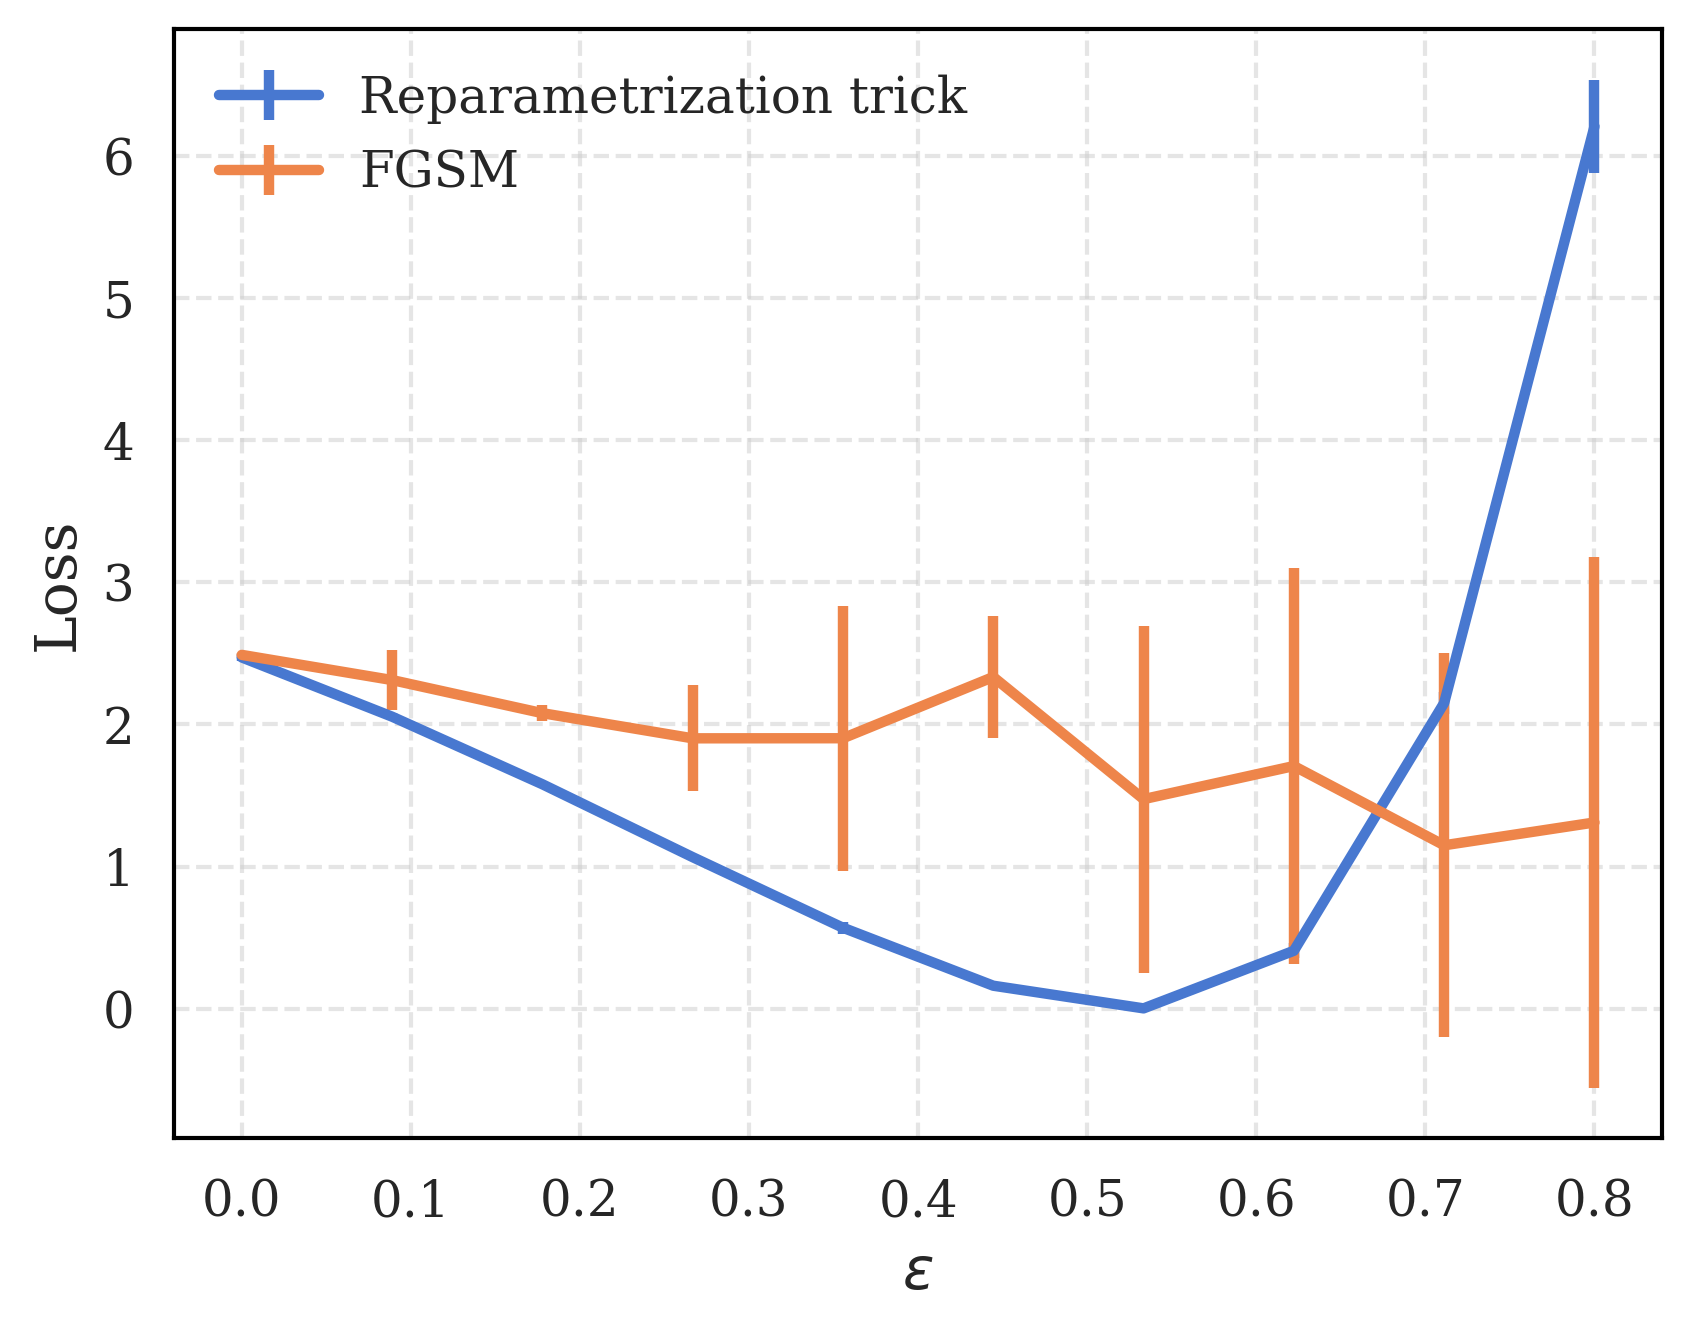

In [30]:
# Plot loss as a function of the size of the perturbation for reparametrization trick attack
x_adv = torch.tensor(X_test[17,:].copy(), dtype=torch.float32, requires_grad=True)
y_star = 3.0
losses_total_rep = []
losses_total_fgsm = []
epsilons = np.linspace(0, .8, 10)

def compute_loss_rep(epsilon):
    if epsilon > 0.5:
        lr = 1e-3
    else:
        lr = 1e-4
    x_adv_values, loss_values, func_values = attack(x_adv, model, y_star, epsilon=epsilon, learning_rate=lr, num_iterations=1000, samples_per_iteration=1000, func=expy2)    
    y_adv = model.sample_predictive_distribution(torch.tensor(x_adv_values[-1]).unsqueeze(1), 1000)
    func_mean = torch.exp(y_adv ** 2 / 100).mean()
    return (func_mean - y_star) ** 2

def compute_loss_fgsm(epsilon):
    x_adv_fgsm = attack_fgsm(x_adv, model, y_star, epsilon=epsilon, func=expy2)
    y_adv_fgsm = model.sample_predictive_distribution(x_adv_fgsm.unsqueeze(1), 1000)
    func_mean = torch.exp(y_adv_fgsm ** 2 / 100).mean()
    return (func_mean - y_star) ** 2

for _ in range(4):
    print(_)
    losses_rep = Parallel(n_jobs=5)(delayed(compute_loss_rep)(epsilon) for epsilon in epsilons)
    losses_fgsm = Parallel(n_jobs=5)(delayed(compute_loss_fgsm)(epsilon) for epsilon in epsilons)

    losses_total_rep.append(losses_rep)
    losses_total_fgsm.append(losses_fgsm)

# plot the mean and std of the losses
plt.errorbar(epsilons, np.mean(losses_total_rep, axis=0), yerr=2*np.std(losses_total_rep, axis=0), label='Reparametrization trick')
plt.errorbar(epsilons, np.mean(losses_total_fgsm, axis=0), yerr=2*np.std(losses_total_fgsm, axis=0), label='FGSM')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('Loss')

<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2990847/1520320696.py:4: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


(-0.02, 3.0)

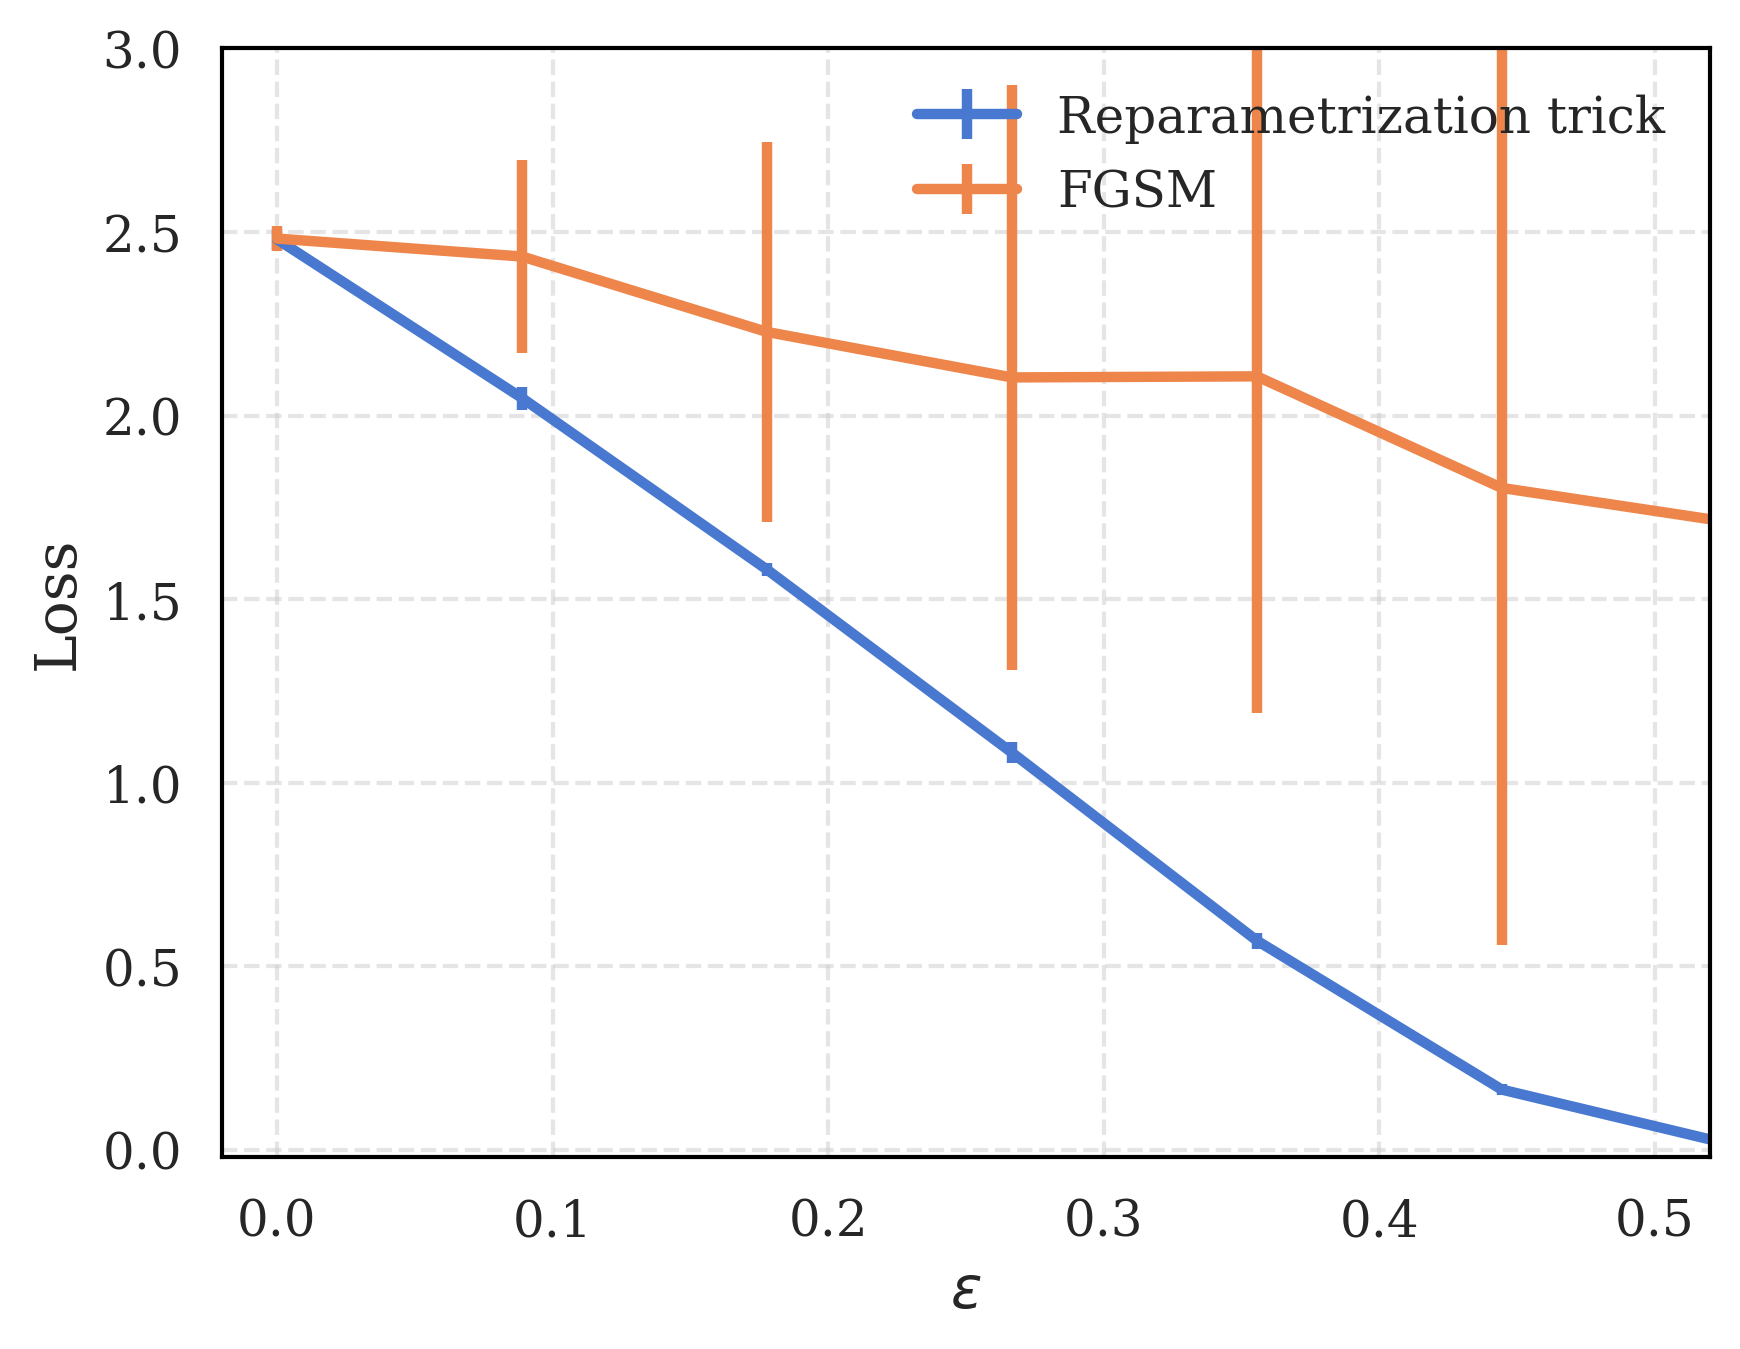

In [21]:
plt.errorbar(epsilons, np.mean(losses_total_rep, axis=0), yerr=2*np.std(losses_total_rep, axis=0), label='Reparametrization trick')
plt.errorbar(epsilons, np.mean(losses_total_fgsm, axis=0), yerr=2*np.std(losses_total_fgsm, axis=0), label='FGSM')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('Loss')
plt.xlim(-.02, .52)
plt.ylim(-.02, 3)

#### Compare attacking one point with l1 or l2 projection

In [32]:
x = torch.tensor(X_test[17,:], dtype=torch.float32)
y_star = 3.0
x_adv_values, loss_values, func_values = attack(x, model, y_star, epsilon=0.3, learning_rate=1e-4, num_iterations=1000, samples_per_iteration=1000, func=expy2, projection=l1_projection)
x_adv_l1 = x_adv_values[-1]
x_adv_values, loss_values, func_values = attack(x, model, y_star, epsilon=0.3, learning_rate=1e-4, num_iterations=1000, samples_per_iteration=1000, func=expy2)
x_adv_l2 = x_adv_values[-1]
print(x,'\n', x_adv_l1,'\n', x_adv_l2)
print(x-x_adv_l1, '\n', x-x_adv_l2)

tensor([0.3970, 0.2941, 0.0375, 0.0215, 0.0134, 0.0015, 0.0234, 0.8924]) 
 [ 0.4952216   0.29411766 -0.01364675  0.17207816  0.01339724  0.00153519
  0.02337938  0.8924303 ] 
 [ 0.5569643   0.32159406 -0.07611026  0.23371308  0.06963073 -0.04683125
  0.01119825  0.8851225 ]
tensor([-0.0983,  0.0000,  0.0512, -0.1506,  0.0000,  0.0000,  0.0000,  0.0000]) 
 tensor([-0.1600, -0.0275,  0.1136, -0.2122, -0.0562,  0.0484,  0.0122,  0.0073])


## Variance as objective

In [22]:
y_star = 30
epsilon = 2
x_adv = X_test[17,:].copy()
x_adv = torch.tensor(x_adv, dtype=torch.float32, requires_grad=True)

def var(x, y):
    return torch.var(y)

x_adv_values, loss_values, func_values = attack(x_adv, model, y_star, learning_rate= 1e-2, samples_per_iteration=1000, num_iterations=10000, epsilon=epsilon, func=var)

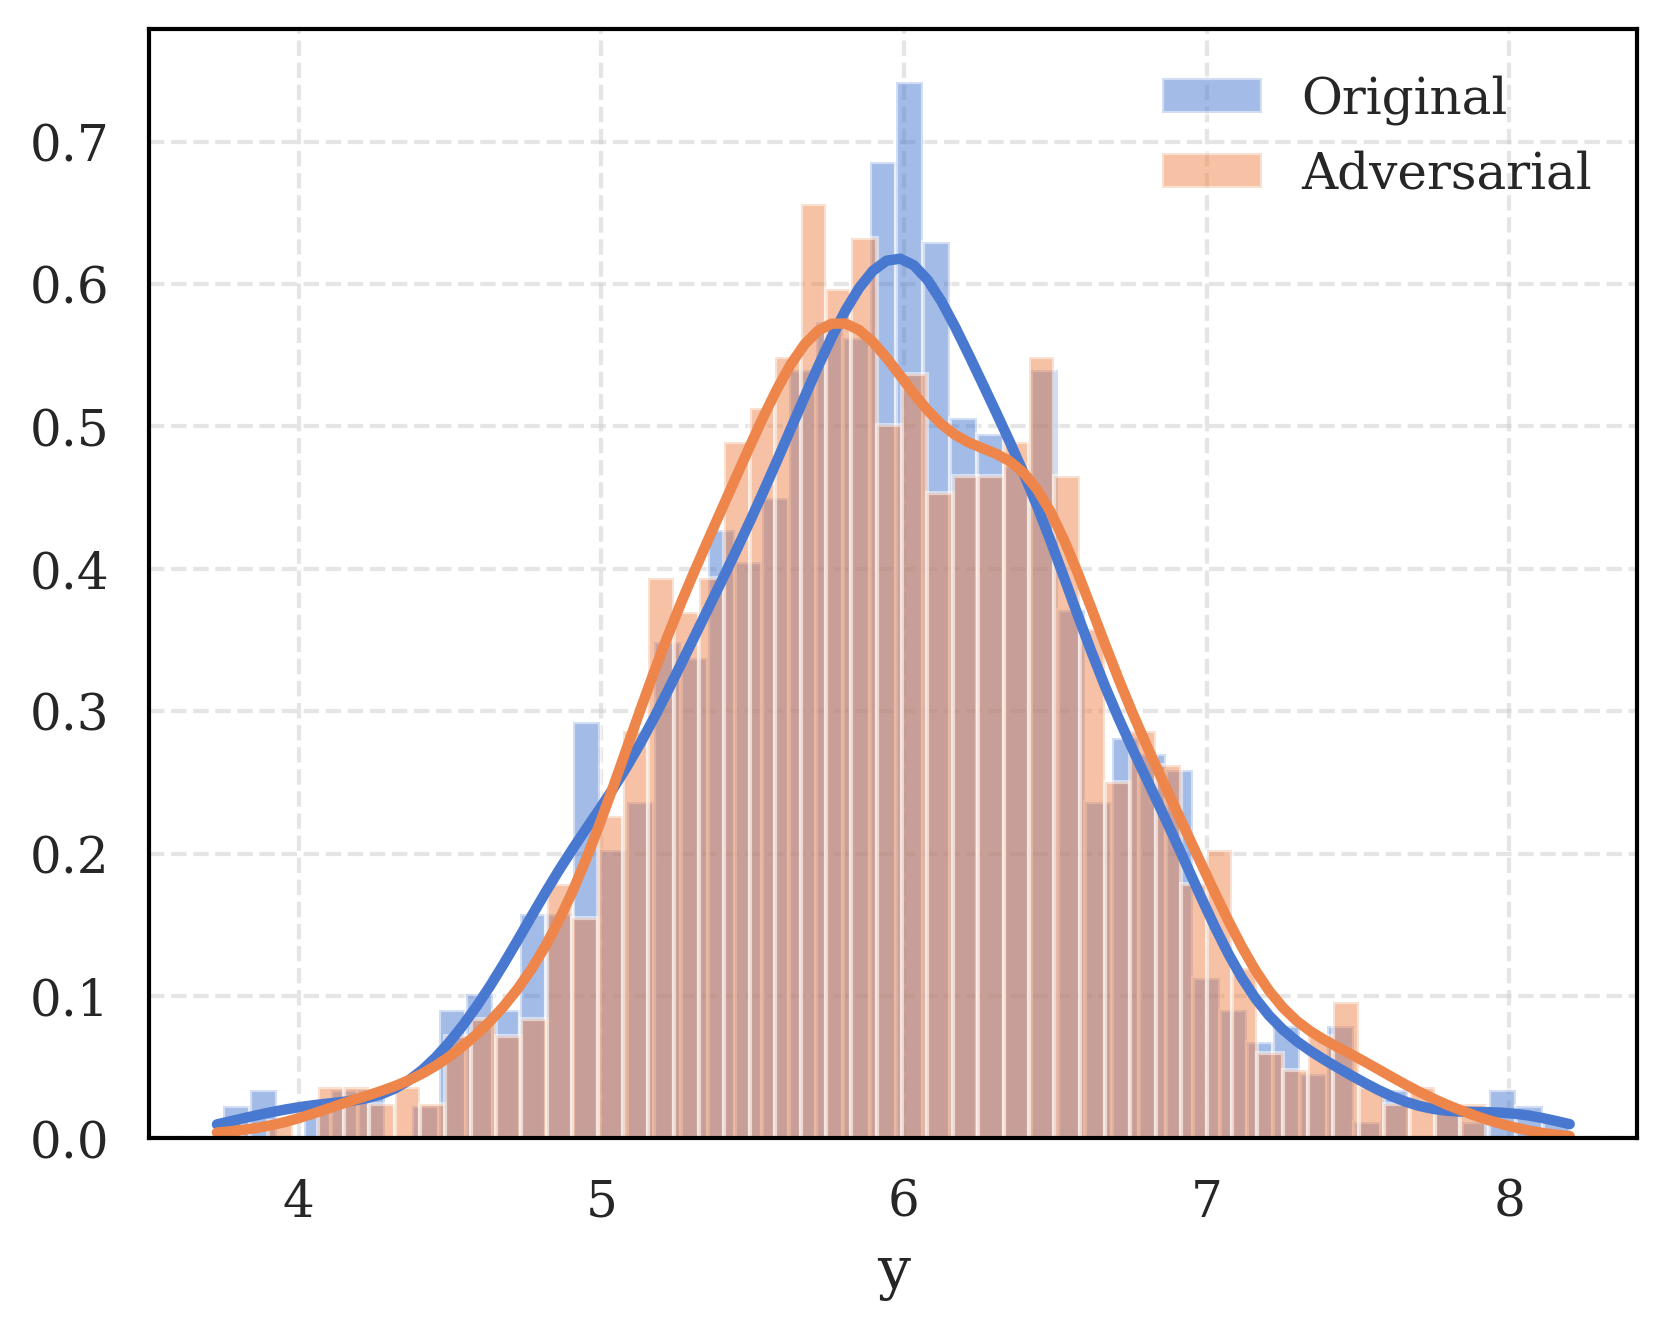

In [23]:
plot_ppds(model, x_adv.unsqueeze(1), torch.tensor(x_adv_values[-1]).unsqueeze(1), num_samples=1000)

# Comparison of 3 datasets: Wine, energy and housing

In [24]:
# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
data = pd.read_excel(url)

# The last two columns are the target variables (Heating Load and Cooling Load)
X = data.iloc[:, :-2].values  # Covariates
y = data.iloc[:, -2].values  # Heating Load
y_energy = y / 4  # to make the target variable similar to the other datasets

# Normalize the data
scaler = MinMaxScaler()
X_energy = scaler.fit_transform(X)

In [25]:
# Wine Quality dataset with response in {3, 4, 5, 6, 7, 8}, 11 features and 4898 samples

# URL to the Wine Quality dataset (for example, from UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
# Load the dataset directly into a Pandas DataFrame
data = pd.read_csv(url, delimiter=";")

X = data.iloc[:, :-1].values
y_wine = data.iloc[:, -1].values

# Normalize the data
scaler = MinMaxScaler()
X_wine = scaler.fit_transform(X)

In [26]:
# Housing dataset
california_housing = fetch_california_housing(as_frame=True)

X = california_housing.data.values
y_housing = california_housing.target.values

X_housing = MinMaxScaler().fit_transform(X)

In [27]:
# For all 3 datasets: Fit the model, compute the average rmse over the test set for the original data and the adversarial examples with epsilon = 0.2 and epsilon = 0.5
datasets = ['energy', 'wine', 'housing']
epsilons = [0, 0.2, 0.5]

results = []
results_attack = []

for dataset in datasets:
    print(f'Running dataset {dataset}')
    if dataset == 'energy':
        X, y = X_energy, y_energy
    elif dataset == 'wine':
        X, y = X_wine, y_wine
    elif dataset == 'housing':
        X, y = X_housing, y_housing

    
    results_dataset = []
    results_dataset_attack = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
        y_star = y_train.mean() * 2

        model = NormalInverseGammaPriorLinearRegression(prior_params={
            'mu': torch.zeros(X_train.shape[1]), 
            'lam': torch.eye(X_train.shape[1]), 
            'a': torch.tensor([1]), 
            'b': torch.tensor([1])},)
        data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
        model.fit(data)

        X_test = X_test[:100, :]
        y_test = y_test[:100]

        res_it = []
        res_it_attack = []
        for epsilon in epsilons:
            rmse = []
            rmse_attack = []
            for i in range(X_test.shape[0]):
                x_adv = torch.tensor(X_test[i,:].copy(), dtype=torch.float32, requires_grad=True)
                x_adv_values, loss_values, func_values = attack(x_adv, model, y_star, epsilon=epsilon, learning_rate=1e-4, num_iterations=1000, early_stopping_patience=20)
                y_adv = model.mu @ x_adv_values[-1]
                rmse.append((y_adv - y_test[i]) ** 2)
                rmse_attack.append((y_adv - y_star) ** 2)
            res_it.append(np.sqrt(np.mean(rmse)))
            res_it_attack.append(np.sqrt(np.mean(rmse_attack)))
        results_dataset.append(res_it)
        results_dataset_attack.append(res_it_attack)
    results.append(results_dataset)
    results_attack.append(results_dataset_attack)

Running dataset energy


/home/pgarcia/AdvReg/src/models/conjugate_bayes_lin_reg.py:119: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1724788957849/work/aten/src/ATen/native/TensorShape.cpp:3697.)
  b_n = self.b + 0.5 * (y.T @ y + self.mu.T @ self.lam @ self.mu - mu_n.T @ lam_n @ mu_n)


Running dataset wine
Running dataset housing


In [28]:
# Display as a table
results_array = np.array(results).mean(axis=1)
results_array = np.round(results_array, 3)
results_df = pd.DataFrame(results_array, columns=epsilons, index=datasets)
results_df

,0.0,0.2,0.5
energy,0.798,1.381,2.895
wine,0.897,2.037,4.751
housing,0.799,2.311,2.367


In [29]:
# Display as a table
results_array = 2 * np.array(results).std(axis=1)
results_array = np.round(results_array, 3)
results_df = pd.DataFrame(results_array, columns=epsilons, index=datasets)
results_df

,0.0,0.2,0.5
energy,0.098,0.162,0.157
wine,0.145,0.269,0.552
housing,0.076,0.142,0.120


In [30]:
# Display as a table
results_array = np.array(results_attack).mean(axis=1)
results_array = np.round(results_array, 3)
results_df = pd.DataFrame(results_array, columns=epsilons, index=datasets)
results_df

,0.0,0.2,0.5
energy,5.964,4.937,3.524
wine,5.943,4.071,1.387
housing,2.271,0.360,0.025


In [31]:
# Display as a table
results_array = 2 * np.array(results_attack).std(axis=1)
results_array = np.round(results_array, 3)
results_df = pd.DataFrame(results_array, columns=epsilons, index=datasets)
results_df

,0.0,0.2,0.5
energy,0.588,0.581,0.534
wine,0.129,0.248,0.430
housing,0.129,0.082,0.002
